In [124]:
# Import Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import unittest

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
# Load the Dataset 
df= pd.read_csv(r"C:\Users\User\Documents\BAN 6440\email_spam.csv")

In [128]:
df.head()

,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   84 non-null     object
 1   text    84 non-null     object
 2   type    84 non-null     object
dtypes: object(3)
memory usage: 2.1+ KB


In [132]:
df.shape

(84, 3)

In [10]:
# Checking for missing values
df.isnull().sum()

title    0
text     0
type     0
dtype: int64

In [12]:
#check duplicates 
df.duplicated().sum()

1

In [14]:
#Drop Duplicates
df.drop_duplicates(inplace=True)

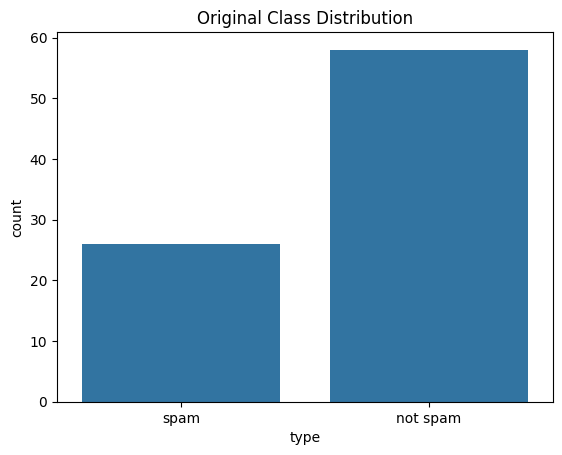

In [134]:
#Visualize Original Class Distribution
sns.countplot(x='type', data=df)
plt.title("Original Class Distribution")
plt.show()

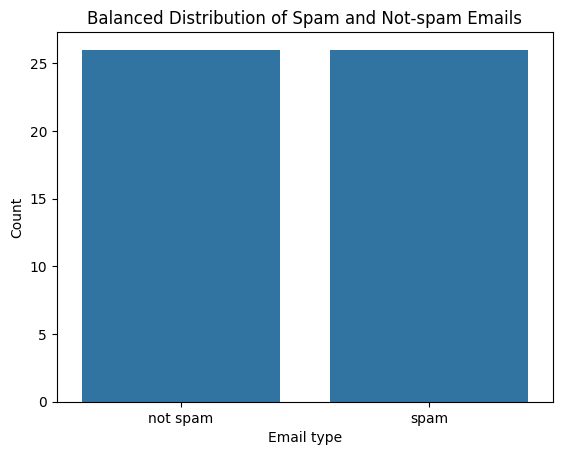

In [70]:
# Separate spam and not-spam emails using numerical labels
notspam_msg = df[df['type'] == 'not spam']
spam_msg = df[df['type'] == 'spam']

# Downsample not-spam (majority class) to match spam (minority class)
notspam_msg_balanced = notspam_msg.sample(n=len(spam_msg), random_state=42)

# Combine the balanced dataset and shuffle it
balanced_data = pd.concat([notspam_msg_balanced, spam_msg])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='type', data=balanced_data)
plt.title("Balanced Distribution of Spam and Not-spam Emails")
plt.xlabel("Email type")
plt.ylabel("Count")
plt.show()


In [90]:
# Clean the text 
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '', regex=False)
lemmatizer = WordNetLemmatizer()
balanced_data.head()

,title,text,label
0,"If coding in C++ is so extremely hard, why do ...",TOP STORIES FOR VIRA\n\nQuora\n?\nIf coding in...,0
1,Limited offer. Hurry up!,\nLess than $1 for any of our 214 million amaz...,1
2,Time is of the Essence!,"Dear Customer,\n\nThe 2022 filing season is al...",1
3,Update: New Twitch Account Linked,Dear denis:\n\nYour Amazon account: denis.supe...,0
4,Meeting with Walid TOMORROW,"Hello Walid,\n\nOur Zoom call meeting is tomor...",1


In [92]:
def clean_text(text):
    stop_words = stopwords.words('english')
    return " ".join([
        lemmatizer.lemmatize(word.lower())
        for word in str(text).split()
        if word.lower() not in stop_words and word not in string.punctuation
    ])
balanced_data['text'] = balanced_data['text'].apply(clean_text)
balanced_data.head()


,title,text,label
0,"If coding in C++ is so extremely hard, why do ...",top story vira quora coding c++ extremely hard...,0
1,Limited offer. Hurry up!,le $1 214 million amazing stock photo illustra...,1
2,Time is of the Essence!,"dear customer, 2022 filing season almost comin...",1
3,Update: New Twitch Account Linked,dear denis: amazon account: denis.supermen888@...,0
4,Meeting with Walid TOMORROW,"hello walid, zoom call meeting tomorrow thursd...",1


In [76]:
# Encode the target labels
label_encoder = LabelEncoder()
balanced_data['label'] = label_encoder.fit_transform(balanced_data['type'])

# Drop original 'type' column
balanced_data.drop('type', axis=1, inplace=True)

# Check result
balanced_data[['label']].value_counts()

label
0        26
1        26
Name: count, dtype: int64

In [108]:
# Vectorization
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = tfidf.fit_transform(balanced_data['text']).toarray()
y = balanced_data['label']

In [110]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [112]:
# Logistic Regression
log_model = LogisticRegression(C=1, penalty='l2', solver='liblinear')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.71      1.00      0.83         5

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



In [114]:
# Linear Regression (Convert regression output to binary class)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
y_pred_lin = np.where(y_pred_lin >= 0.5, 1, 0)

print("Linear Regression Accuracy:", accuracy_score(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))

Linear Regression Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.71      1.00      0.83         5

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



In [116]:
# Perceptron
perc_model = Perceptron()
perc_model.fit(X_train, y_train)
y_pred_perc = perc_model.predict(X_test)

print("Perceptron Accuracy:", accuracy_score(y_test, y_pred_perc))
print(classification_report(y_test, y_pred_perc))

Perceptron Accuracy: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11



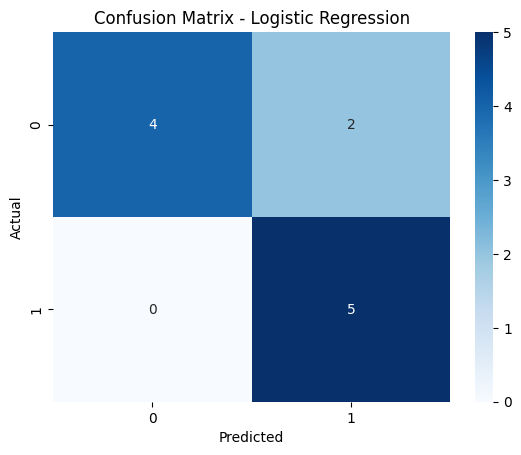

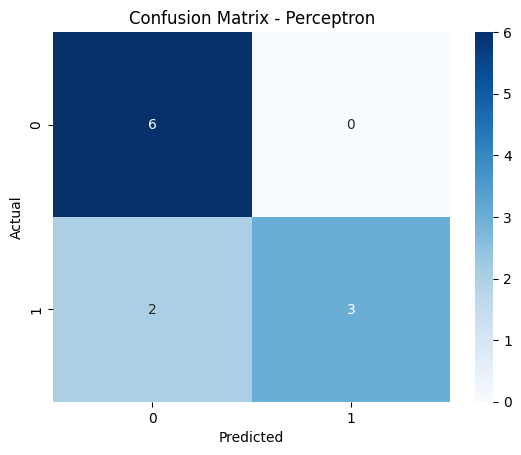

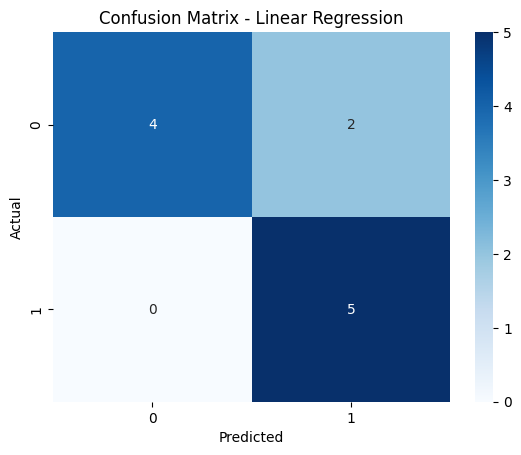

In [118]:
# Confusion Matrix
models = {
    "Logistic Regression": y_pred_log,
    "Perceptron": y_pred_perc,
    "Linear Regression": y_pred_lin
}
for model_name, predictions in models.items():
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [120]:
# Unit test
class TestSpamFilter(unittest.TestCase):

    def test_log_model_accuracy(self):
        acc = accuracy_score(y_test, y_pred_log)
        self.assertGreater(acc, 0.75)

    def test_perceptron_accuracy(self):
        acc = accuracy_score(y_test, y_pred_perc)
        self.assertGreater(acc, 0.70)

    def test_linear_accuracy(self):
        acc = accuracy_score(y_test, y_pred_lin)
        self.assertGreater(acc, 0.60)

# Run tests
unittest.main(argv=[''], verbosity=2, exit=False)


test_linear_accuracy (__main__.TestSpamFilter.test_linear_accuracy) ... ok
test_log_model_accuracy (__main__.TestSpamFilter.test_log_model_accuracy) ... ok
test_perceptron_accuracy (__main__.TestSpamFilter.test_perceptron_accuracy) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK
